In [25]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate, BasePromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain.output_parsers.xml import XMLOutputParser
from pydantic import BaseModel, Field

## Text Loaders and Splitters
from langchain.document_loaders import PyPDFLoader, WebBaseLoader, TextLoader, JSONLoader, UnstructuredXMLLoader, ArxivLoader, WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter, RecursiveJsonSplitter
from langchain_core.documents import Document
import bs4
import requests

## Embeddings
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# import faiss
from langchain_community.vectorstores import FAISS, Chroma
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain import hub
# import pprintr
from langchain_core.runnables import RunnablePassthrough

from langchain.agents import tool
from langchain_community.tools import WikipediaQueryRun, YouTubeSearchTool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import DuckDuckGoSearchRun


from langgraph.graph import StateGraph, END, MessagesState, START
from IPython.display import Image, display
import operator
from typing_extensions import TypedDict
from typing import Annotated, Sequence
# from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

from langgraph.prebuilt import ToolNode, tools_condition
import yfinance as yf


In [12]:
load_dotenv()

True

## Define Model

In [14]:
model = ChatOpenAI(model="gpt-4o", temperature=0.0, max_retries=3)

In [13]:
model.invoke("how are you")

AIMessage(content="I'm just a computer program, so I don't have feelings, but I'm here to help you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 10, 'total_tokens': 36, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C1ExHGwMdbNjlAUdeRvPIyAWJUKV1', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c4b7ca5b-4ce4-48ea-b54c-e928ba86d2b6-0', usage_metadata={'input_tokens': 10, 'output_tokens': 26, 'total_tokens': 36, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Define Custom Tools

In [15]:
@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers."""
    return x * y

@tool
def add(x: int, y: int) -> int:
    """Adds two numbers."""
    return x + y

@tool
def divide(x: int, y: int) -> float:
    """Divides two numbers."""
    if y == 0:
        raise ValueError("Cannot divide by zero.")
    return x / y

@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

## Define Inbuilt tools

In [16]:
search_tool = DuckDuckGoSearchRun()

## Define Nodes

In [17]:
tools = [multiply, add, divide, get_stock_price, search_tool]

In [22]:
llm_with_tools = model.bind_tools(tools)

In [18]:
tool_node = ToolNode(tools=tools)

In [23]:
SYSTEM_PROMPT = """You are a helpful assistant. You can perform calculations, fetch stock prices, and search the web for information."""

def supervisor(state: MessagesState) -> MessagesState:
    user_question = state["messages"]

    question = [SYSTEM_PROMPT] + user_question

    print("Question:", question)

    response = llm_with_tools.invoke(question)

    return {"messages": [response]}


## Define Workflow

In [27]:
workflow = StateGraph(MessagesState)

workflow.add_node("supervisor", supervisor)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "supervisor")
workflow.add_conditional_edges("supervisor", tools_condition)

workflow.add_edge("tools", "supervisor")

In [28]:
react_graph = workflow.compile()

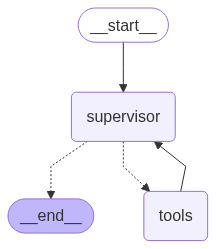

In [29]:
app = workflow.compile()
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [30]:
message = ["What is the speed of light in m/s and multiply it by 10?"]

In [31]:
response=react_graph.invoke({"messages":message})

Question: ['You are a helpful assistant. You can perform calculations, fetch stock prices, and search the web for information.', HumanMessage(content='What is the speed of light in m/s and multiply it by 10?', additional_kwargs={}, response_metadata={}, id='2e7d3d1a-4b0e-40be-b9f0-ef633d99d220')]


In [32]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply it by 10?
================================== Ai Message ==================================

The speed of light in a vacuum is approximately \(299,792,458\) meters per second (m/s). To multiply this by 10, we can perform the calculation:

\[ 299,792,458 \times 10 = 2,997,924,580 \]

So, the result is \(2,997,924,580\) m/s.


In [33]:
message = [HumanMessage(content="What is the speed of light in m/s and multiply it by 10?")]

In [34]:
response=react_graph.invoke({"messages":message})

Question: ['You are a helpful assistant. You can perform calculations, fetch stock prices, and search the web for information.', HumanMessage(content='What is the speed of light in m/s and multiply it by 10?', additional_kwargs={}, response_metadata={}, id='8458b538-eb36-4791-a914-03b903ee8129')]


In [35]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply it by 10?
================================== Ai Message ==================================

The speed of light in a vacuum is approximately \(299,792,458\) meters per second (m/s). To multiply it by 10, we can perform the calculation:

\[ 299,792,458 \times 10 = 2,997,924,580 \]

So, the result is \(2,997,924,580\) m/s.


In [36]:
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
messages = react_graph.invoke({"messages": messages})

Question: ['You are a helpful assistant. You can perform calculations, fetch stock prices, and search the web for information.', HumanMessage(content='add 1000 in the current stock price of Apple.', additional_kwargs={}, response_metadata={}, id='2efbf534-c885-48d4-9cf8-aa7d14df46e8')]
Question: ['You are a helpful assistant. You can perform calculations, fetch stock prices, and search the web for information.', HumanMessage(content='add 1000 in the current stock price of Apple.', additional_kwargs={}, response_metadata={}, id='2efbf534-c885-48d4-9cf8-aa7d14df46e8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FjZC3ikaZh6as0vjldi9isBc', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 251, 'total_tokens': 267, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'reject

In [37]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_FjZC3ikaZh6as0vjldi9isBc)
 Call ID: call_FjZC3ikaZh6as0vjldi9isBc
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $203.35.
================================== Ai Message ==================================
Tool Calls:
  add (call_z3y26U74GZCXwR9pWJZIHPP5)
 Call ID: call_z3y26U74GZCXwR9pWJZIHPP5
  Args:
    x: 203.35
    y: 1000
================================= Tool Message =================================
Name: add

Error: 1 validation error for add
x
  Input should be a valid integer, got a number with a fractional part [type=int_from_float, input_value=203.35, input_type=float]
    For further information visit https://errors.pyd

In [41]:
messages = [HumanMessage(content="can you give me current stock price of Apple with the latest news of the Apple.")]
messages = react_graph.invoke({"messages": messages})

Question: ['You are a helpful assistant. You can perform calculations, fetch stock prices, and search the web for information.', HumanMessage(content='can you give me current stock price of Apple with the latest news of the Apple.', additional_kwargs={}, response_metadata={}, id='f99c333c-7889-41aa-922b-19e7306ef246')]


/Users/mac/Desktop/Agentic-AI/venv-3-10/lib/python3.10/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


Question: ['You are a helpful assistant. You can perform calculations, fetch stock prices, and search the web for information.', HumanMessage(content='can you give me current stock price of Apple with the latest news of the Apple.', additional_kwargs={}, response_metadata={}, id='f99c333c-7889-41aa-922b-19e7306ef246'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1YXIy6po43jNGCPaB9ZGs4m2', 'function': {'arguments': '{"ticker": "AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_DVponKkPf2F707tvAlheKOsG', 'function': {'arguments': '{"query": "Apple latest news"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 256, 'total_tokens': 307, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_

In [42]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you give me current stock price of Apple with the latest news of the Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_1YXIy6po43jNGCPaB9ZGs4m2)
 Call ID: call_1YXIy6po43jNGCPaB9ZGs4m2
  Args:
    ticker: AAPL
  duckduckgo_search (call_DVponKkPf2F707tvAlheKOsG)
 Call ID: call_DVponKkPf2F707tvAlheKOsG
  Args:
    query: Apple latest news
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $203.35.
================================= Tool Message =================================
Name: duckduckgo_search

The official source for news about Apple, from Apple. Read press releases, get updates, watch video and download images. Apple Newsroom is the source for news about Apple. Read press releases, get updates, watch video and download images. 5 days a